# New ts_gen

In [36]:
from utils.meta_eval import TSGenArgs, create_ds_dict, plot_ds
from experiments.meta_eval.me import me_experiment

args = TSGenArgs()
args.n_epochs = 1
args.test_interval = 1

args.batch_size = 128
args.gnn_depth = 1
args.n_layers = 1
args.h_nf = 32

# args.remove_existing_data = True

exp_log = me_experiment(args)

Starting training...
Starting training...
Starting training...
Starting training...
Starting training...
Starting training...
Starting training...
Starting training...
100%|██████████| 53/53 [00:05<00:00, 10.50it/s]
Epoch 1: Training Loss 0.09155187653977778
Epoch 1: Training Loss 0.09155187653977778
Epoch 1: Training Loss 0.09155187653977778
Epoch 1: Training Loss 0.09155187653977778
Epoch 1: Training Loss 0.09155187653977778
Epoch 1: Training Loss 0.09155187653977778
Epoch 1: Training Loss 0.09155187653977778
Epoch 1: Training Loss 0.09155187653977778
7it [00:00, 10.96it/s]
Epoch 1: Test Loss 0.0718315031503906
Epoch 1: Test Loss 0.0718315031503906
Epoch 1: Test Loss 0.0718315031503906
Epoch 1: Test Loss 0.0718315031503906
Epoch 1: Test Loss 0.0718315031503906
Epoch 1: Test Loss 0.0718315031503906
Epoch 1: Test Loss 0.0718315031503906
Epoch 1: Test Loss 0.0718315031503906
Best Test Loss 0.0718315031503906 on Epoch 1
Best Test Loss 0.0718315031503906 on Epoch 1
Best Test Loss 0.071831

In [33]:
len(exp_log.test_logs[-1].Ds)

7

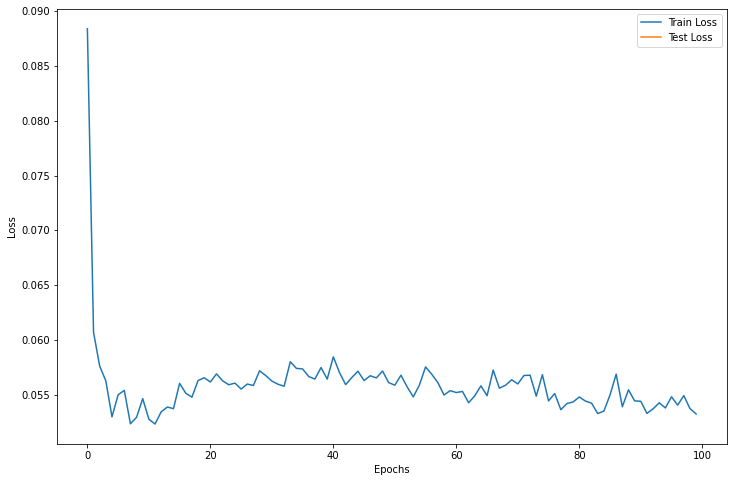

In [94]:
import numpy as np

def save_Ds(exp_log, file_name, save_to_log_dir = False, D_folder='experiments/meta_eval/d_inits/'):
    # assert that each Ds[i] has same length cos otherwise batching not working
    test_Ds = np.concatenate(exp_log.test_logs[-1].Ds, 0)[1684:2526] # final test log, new dim = num_rxns x 21 x 21
    assert len(test_Ds) == 842, f"Should have 842 test_D_inits when unbatched, you have {len(test_Ds)}."
    np.save(D_folder + file_name, test_Ds)
    if save_to_log_dir:
        np.save(exp_log.args.log_dir + 'D' + file_name, test_Ds)

def save_Ws(exp_log, file_name, save_to_log_dir = False, W_folder='experiments/meta_eval/ws/'):
    test_Ws = np.concatenate(exp_log.test_logs[-1].Ws, 0)[1684:2526].squeeze() # final test log, and remove singleton dims; new dim = num_rxns x 21 x 21
    assert len(test_Ws) == 842, f"Should have 842 test_Ws when unbatched, you have {len(test_Ws)}."
    np.save(W_folder + file_name, test_Ws)
    if save_to_log_dir:
        np.save(exp_log.args.log_dir + 'W' + file_name, test_Ws)

file_name = '20.npy'
save_Ds(exp_log, file_name, save_to_log_dir=False)
save_Ws(exp_log, file_name, False)
exp_log.plot_loss(save_fig = False)

In [26]:
args.n_rxns // args.batch_size

len(exp_log.test_logs[-1].Ds[6])

74

In [34]:
import numpy as np
def check_batches(self, test_log_files):
    n_train = int(np.floor(args.tt_split * self.args.n_rxns))
    n_test = self.args.n_rxns - n_train
    full_batches = n_test // self.args.batch_size
    remaining_batches = 0 if n_test % self.args.batch_size == 0 else 1
    total_batches = full_batches + remaining_batches
    return len(test_log_files) == total_batches

check_batches(exp_log, exp_log.test_logs[-1].Ds)

True

In [37]:
file_name = 'test.npy'
D_folder = 'experiments/meta_eval/d_inits/'
W_folder = 'experiments/meta_eval/ws/'

exp_log.save_Ds(file_name, D_folder, save_to_log_dir=True)
exp_log.save_Ws(file_name, W_folder, save_to_log_dir=True)
exp_log.plot_loss(save_fig = True)

AssertionError: You don't have the same number of batched D files as batches.

### e=100,b=8,h=256, g/l 
- 09/08: no init (dw): 2(2500, 32), 3(2100s, 22), 4(1200, 11) 
- 09/08 no opt (pow): 6(3700, 32), 7(t=3500, 22), 5(2000, 11), 8(t=2400, 11) [6,1,5]
- 09/08: full (opt): 9(3900, 32), 10(3600, 22), 1(?, 11)

### e=100, b=32
- 19-1033 20.npy: g=1,l=2,h=128, t=1500s
- 19-1110 21.npy: g=4,l=1,h=64, t=1750s

/anaconda/envs/3d-rdkit/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/anaconda/envs/3d-rdkit/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/anaconda/envs/3d-rdkit/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with si

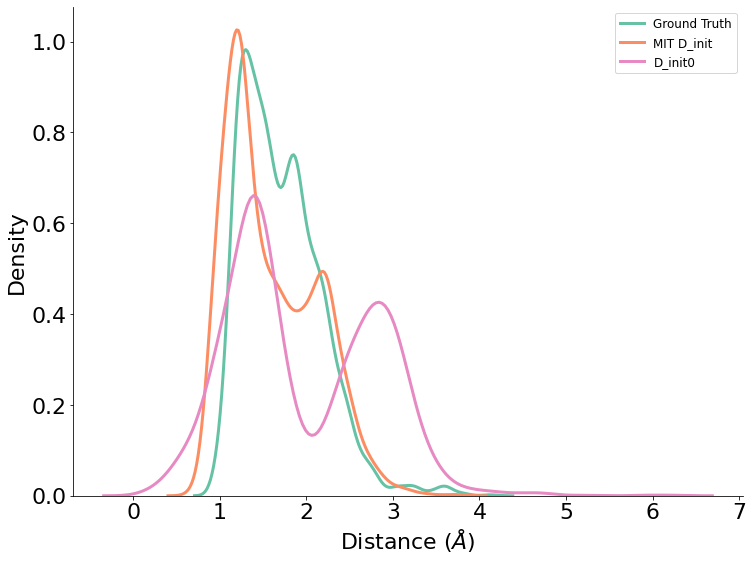

In [90]:
import os
from utils.meta_eval import create_ds_dict, plot_ds

# create ds_dict and plot d_inits
mols_folder = 'data/raw/'
d_folder = 'experiments/meta_eval/d_inits/'
d_plot_name = None # os.path.join(os.path.dirname(args.log_dir), '22') # None won't save fig

# ens plots
#ens_plot_folder = 'experiments/meta_eval/ens_figs/'
#ens_plot_name = os.path.join(os.path.dirname(ens_plot_folder), 'pow-ens2') # None won't save fig
#ens_plot_name = '11'

# standard: 1(e=100,t=2500s),  6(e=100, t=3850s)

# e=100,b=8,h=256, g/l 
# 09/08: no init (dw): 2(2500, 32), 3(2100s, 22), 4(1200, 11) 
# 09/08 no opt (pow): 6(3700, 32), 7(t=3500, 22), 5(2000, 11), 8(t=2400, 11) [6,1,5]
# 09/08: full (opt): 9(3900, 32), 10(3600, 22), 1(?, 11)


d_files = ['test.npy'] 
ds_not_to_print = ['lin_approx']
ds_dict = create_ds_dict(d_files, d_folder, mols_folder) # TODO: create default d_init class for these?
plot_ds(ds_dict, ds_not_to_print, d_plot_name)

In [29]:
f1 = np.load(d_folder + '22.npy')
f2 = np.load(d_folder + '23.npy')
f1 == f2

array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  Tr

## Ensemble

Average all produced $D_{inits}s$ then plot.

C:\Users\Avish\miniconda3\envs\3d-rdkit\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Avish\miniconda3\envs\3d-rdkit\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Avish\miniconda3\envs\3d-rdkit\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-leve

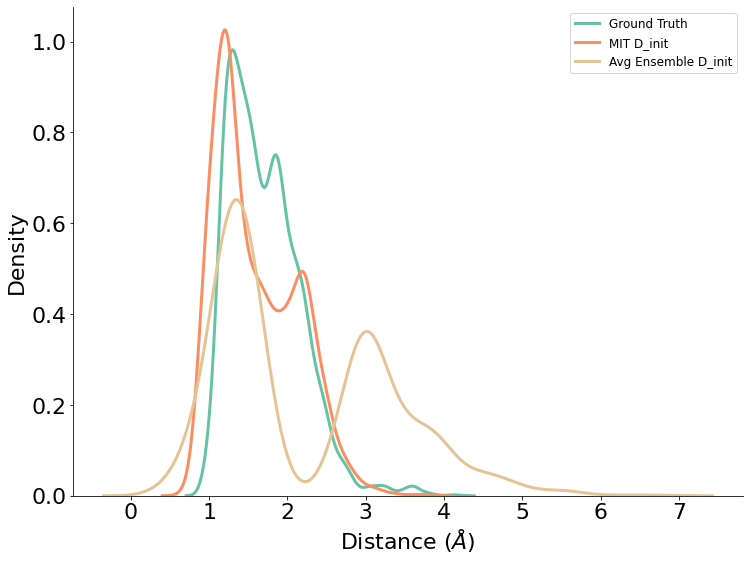

In [15]:
# from utils.meta_eval import ensemble_plot

d_files = ['6.npy', '1.npy', '5.npy'] 
ds_dict = create_ds_dict(d_files, d_folder, mols_folder)
ds_not_to_print = ['lin_approx']

NUM_STD_DS = 3

def ensemble_plot(ds_dict, ds_not_to_print, print_my_ds = False, name = None):
    num_my_ds = len(ds_dict) - NUM_STD_DS
    ens_ds = []
    for i in range(len(ds_dict['mit'][0])):
        ens_d = 0
        for j in range(0, num_my_ds):
            ens_d += ds_dict[f'D_init{j}'][0][i]
        ens_d /= num_my_ds
        ens_ds.append(ens_d)
    ds_dict['ens'] = (ens_ds, "Avg Ensemble D_init")

    if not print_my_ds:
        for j in range(0, num_my_ds):
            ds_not_to_print.append(f'D_init{j}')

    plot_ds(ds_dict, ds_not_to_print, name)

# ens_plot_name = os.path.join(os.path.dirname(ens_plot_folder), 'dw-ens')
ensemble_plot(ds_dict, ds_not_to_print, name = 'pow-ens2')